# Data Science Challenge : Hotel_Booking_Cancellations

In [1]:
# If additional packages are needed but are not installed by default, uncomment the last two lines of this cell
# and replace <package list> with a list of additional packages.
# This will ensure the notebook has all the dependencies and works everywhere

#import sys
#!{sys.executable} -m pip install <package list>

In [2]:
# Libraries
import pandas as pd
import numpy as np
from collections import defaultdict
pd.set_option("display.max_columns", 101)

#sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn import naive_bayes

#Graphviz
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(10,5)})
sns.set_style("whitegrid")

## Data Description

Column | Description
:---|:---
`id` | Unique identifier for each booking.
`lead_time` | Time between booking date and reservation date (in days)
`arrival_week` | Week number of the arrival date.
`duration` | Booking duration (in Days)
`prev_cancel` | Number of previous bookings that were cancelled by the customer prior to the current booking.
`booking_changes` | Number of changes/amendments made to the booking from the moment the booking was entered on the PMS until the moment of check-in or cancellation. 
`waiting_period` | Waiting period for booking confirmation (in Days)	
`per_Day_price` | Per night booking price (in US $).
`parking` | Number of car parking spaces required by the customer.
`special_request` | Number of special requests made by the customer.
`segment` | Market segment designation. In categories, “TA” means “Travel Agents” and “TO” means “Tour Operators”.
`deposit` | Whether the customer made a deposit to guarantee the booking.
`cust_type` | Type of booking, assuming one of four categories.
`is_cancelled` |Value indicating if the booking was cancelled (1) or not (0).

## Data Wrangling & Visualization

In [3]:
# The dataset is already loaded below
data = pd.read_csv("train.csv")

In [4]:
print(data.shape)
data.head()

(3000, 14)


,id,lead_time,arrival_week,duration,prev_cancel,booking_changes,waiting_period,per_Day_price,parking,special_request,segment,deposit,cust_type,is_cancelled
0,200,245,13,5,0,0,0,78.26,0,2,Online TA,No Deposit,Transient,0
1,201,170,25,2,0,0,0,130.50,0,0,Online TA,No Deposit,Transient,0
2,202,304,45,3,0,0,0,89.00,0,0,Offline TA/TO,Non Refund,Transient,1
3,203,19,7,1,0,0,0,82.13,0,2,Online TA,No Deposit,Transient,0
4,204,214,27,4,0,0,0,89.10,0,1,Direct,No Deposit,Transient-Party,0


In [5]:
#Explore columns
data.columns

Index(['id', 'lead_time', 'arrival_week', 'duration', 'prev_cancel',
       'booking_changes', 'waiting_period', 'per_Day_price', 'parking',
       'special_request', 'segment', 'deposit', 'cust_type', 'is_cancelled'],
      dtype='object')

In [6]:
#Description
data.describe()

,id,lead_time,arrival_week,duration,prev_cancel,booking_changes,waiting_period,per_Day_price,parking,special_request,is_cancelled
count,3000.000000,3000.0000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,1699.500000,110.8670,27.215333,2.187333,0.084667,0.189000,3.325000,104.660693,0.022333,0.547667,0.409667
std,866.169729,112.8239,13.414008,1.449692,0.392704,0.569257,20.426611,38.304952,0.147790,0.786512,0.491854
min,200.000000,0.0000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,949.750000,23.0000,17.000000,1.000000,0.000000,0.000000,0.000000,79.000000,0.000000,0.000000,0.000000
50%,1699.500000,75.0000,28.000000,2.000000,0.000000,0.000000,0.000000,99.000000,0.000000,0.000000,0.000000
75%,2449.250000,166.0000,38.000000,3.000000,0.000000,0.000000,0.000000,125.000000,0.000000,1.000000,1.000000
max,3199.000000,629.0000,53.000000,18.000000,11.000000,13.000000,391.000000,313.670000,1.000000,5.000000,1.000000


In [7]:
# Check missing values
data.isnull().sum()

id                 0
lead_time          0
arrival_week       0
duration           0
prev_cancel        0
booking_changes    0
waiting_period     0
per_Day_price      0
parking            0
special_request    0
segment            0
deposit            0
cust_type          0
is_cancelled       0
dtype: int64

In [8]:
# Check the type of features
data.dtypes

id                   int64
lead_time            int64
arrival_week         int64
duration             int64
prev_cancel          int64
booking_changes      int64
waiting_period       int64
per_Day_price      float64
parking              int64
special_request      int64
segment             object
deposit             object
cust_type           object
is_cancelled         int64
dtype: object

Text(0, 0.5, 'Frequency')

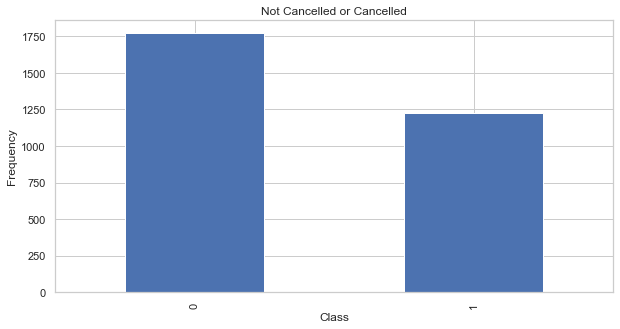

In [9]:
# Frequecy of Not Cancelled or Cancelled
count_classes = pd.value_counts(data['is_cancelled'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Not Cancelled or Cancelled")
plt.xlabel("Class")
plt.ylabel("Frequency")

In [10]:
print('Percent of the class for full_term_subscription \n' )
print((data.is_cancelled.value_counts()*100)/len(data))

Percent of the class for full_term_subscription 

0    59.033333
1    40.966667
Name: is_cancelled, dtype: float64


Text(0, 0.5, 'Percentage of Bookings ')

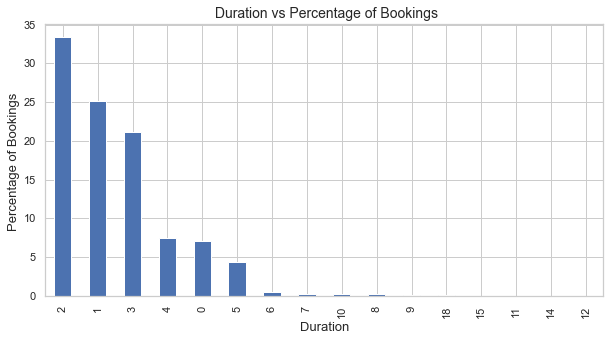

In [11]:
#  Duration vs Percentage of Bookings
((data.duration.value_counts()/data.shape[0])*100).plot(kind='bar')

plt.title(" Duration vs Percentage of Bookings",fontsize = 14)
plt.xlabel('Duration',fontsize = 13)
plt.ylabel('Percentage of Bookings ',fontsize = 13)

Overall 34% of the people are staying of maximum of 2 days.

Text(0, 0.5, 'Percentage of Bookings ')

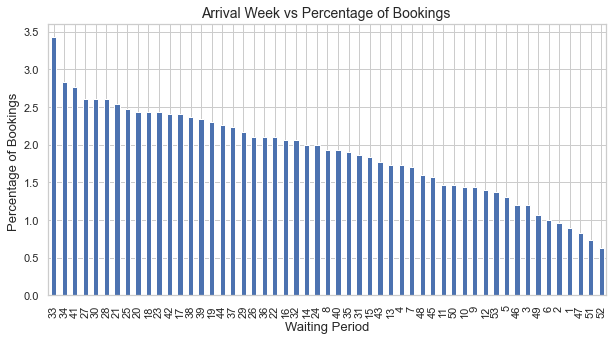

In [12]:
#  Arrival Week vs Percentage of Bookings
((data.arrival_week.value_counts()/data.shape[0])*100).plot(kind='bar')

plt.title("Arrival Week vs Percentage of Bookings ",fontsize = 14)
plt.xlabel('Waiting Period',fontsize = 13)
plt.ylabel('Percentage of Bookings ',fontsize = 13)

Around 3.5% of the bookings has waiting period for booking confirmation for 33 days.

Text(0, 0.5, 'Percentage of Bookings ')

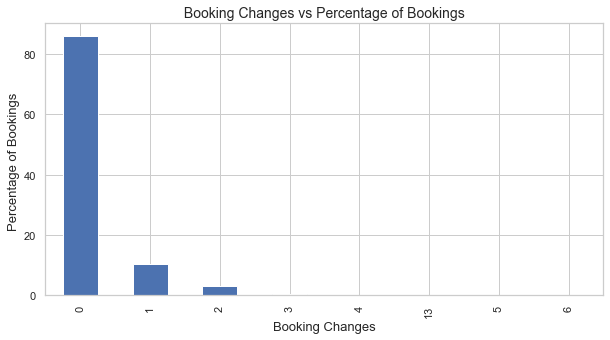

In [13]:
# Booking Changes vs Percentage of Bookings
((data.booking_changes.value_counts()/data.shape[0])*100).plot(kind='bar')

plt.title(" Booking Changes vs Percentage of Bookings ",fontsize = 14)
plt.xlabel('Booking Changes',fontsize = 13)
plt.ylabel('Percentage of Bookings ',fontsize = 13)

More than 80% bookings has no bookings changes.

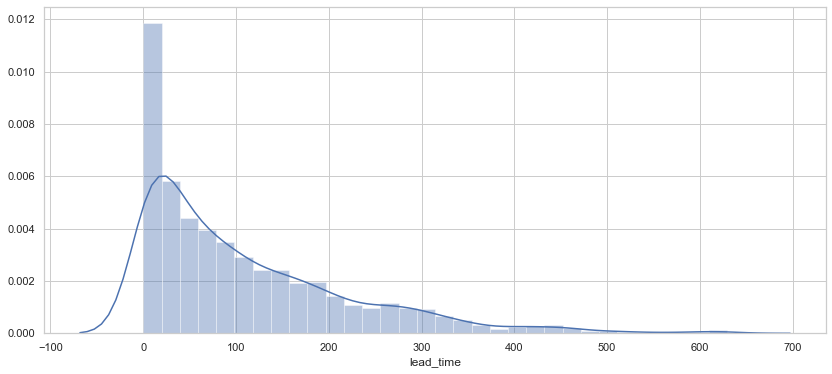

In [14]:
plt.figure(figsize=(14,6))
sns.distplot(data['lead_time'])
plt.show()

Text(0, 0.5, 'Duration ')

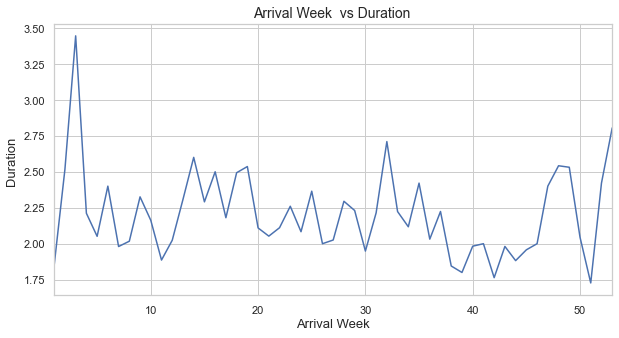

In [15]:
# Arrival Week  vs Duration
data.groupby('arrival_week')['duration'].mean().plot()

plt.title("Arrival Week  vs Duration ",fontsize = 14)
plt.xlabel('Arrival Week',fontsize = 13)
plt.ylabel('Duration ',fontsize = 13)

Text(0, 0.5, 'Lead Time')

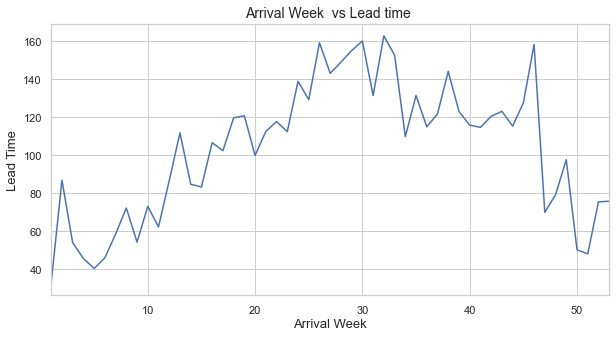

In [16]:
# Arrival Week  vs Lead Time
data.groupby('arrival_week')['lead_time'].mean().plot()

plt.title("Arrival Week  vs Lead time ",fontsize = 14)
plt.xlabel('Arrival Week',fontsize = 13)
plt.ylabel('Lead Time',fontsize = 13)

The average maximum of the arrivals vs lead time is happing at the 160 days.

Text(0, 0.5, 'Booking Changes')

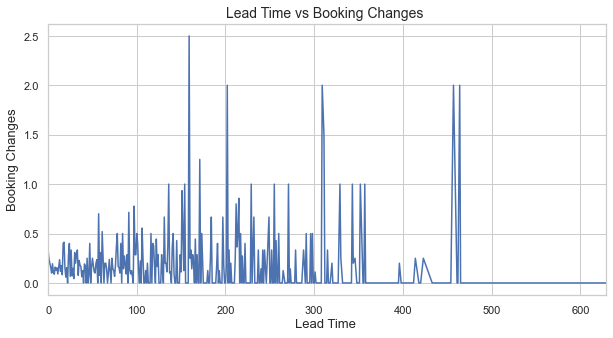

In [17]:
# Lead Time vs Booking Changes
data.groupby('lead_time')['booking_changes'].mean().plot()

plt.title("Lead Time vs Booking Changes ",fontsize = 14)
plt.xlabel('Lead Time ',fontsize = 13)
plt.ylabel('Booking Changes',fontsize = 13)

Text(0, 0.5, 'per_Day_price')

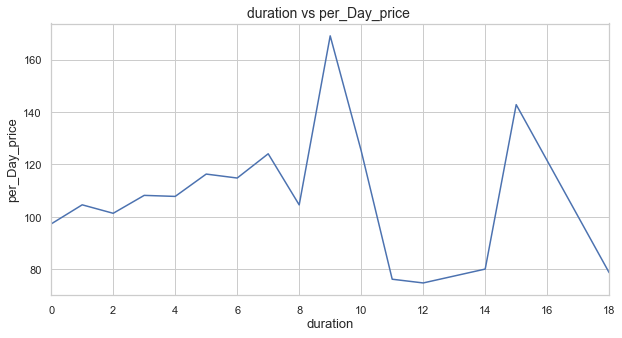

In [18]:
# Duration  vs  Per day price charge
data.groupby('duration')['per_Day_price'].mean().plot()

plt.title("duration vs per_Day_price ",fontsize = 14)
plt.xlabel('duration',fontsize = 13)
plt.ylabel('per_Day_price',fontsize = 13)

The mean value for duration per day prices is maximum for 9 days for 170 USD.

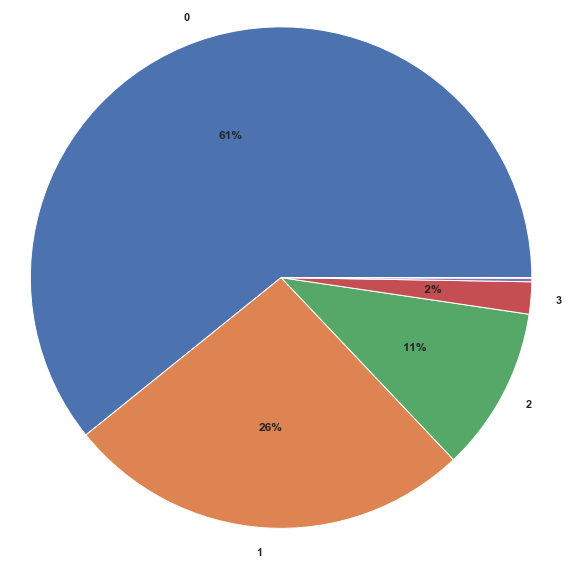

In [19]:
# Percent of Special Requests
i = 0
col_count = []
for col in data['special_request'].value_counts().index:
    col_count.append([col, data['special_request'].value_counts()[i]])
    i = i+1
    
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(8, 8))
col_count.sort(key = lambda x:x[1], reverse = True)
labels, sizes = zip(*col_count)
labels_selected = [n if v > sum(sizes) * 0.01 else '' for n, v in col_count]
ax.pie(sizes, labels=labels_selected,autopct = lambda x:'{:2.0f}%'.format(x) if x > 1 else '',
       shadow=False, startangle=0)
ax.axis('equal')
plt.tight_layout()

61% of the bookings don't have any special requests.

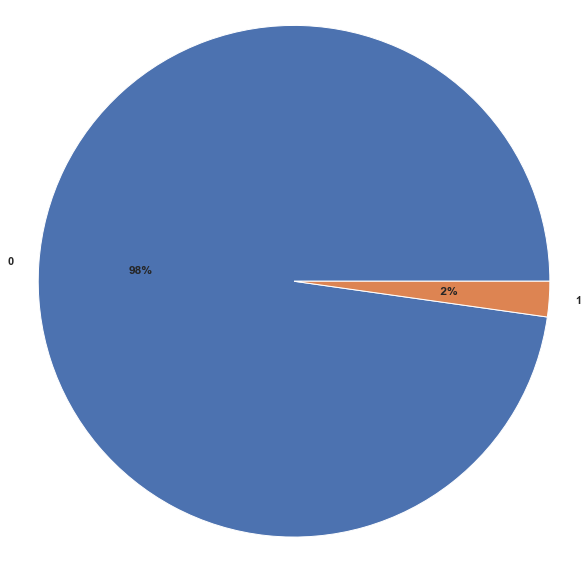

In [20]:
# Percent of Parking
i = 0
col_count = []
for col in data['parking'].value_counts().index:
    col_count.append([col, data['parking'].value_counts()[i]])
    i = i+1
    
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(8, 8))
col_count.sort(key = lambda x:x[1], reverse = True)
labels, sizes = zip(*col_count)
labels_selected = [n if v > sum(sizes) * 0.01 else '' for n, v in col_count]
ax.pie(sizes, labels=labels_selected,autopct = lambda x:'{:2.0f}%'.format(x) if x > 1 else '',
       shadow=False, startangle=0)
ax.axis('equal')
plt.tight_layout()

98% of the people booked hotel don't use parking.

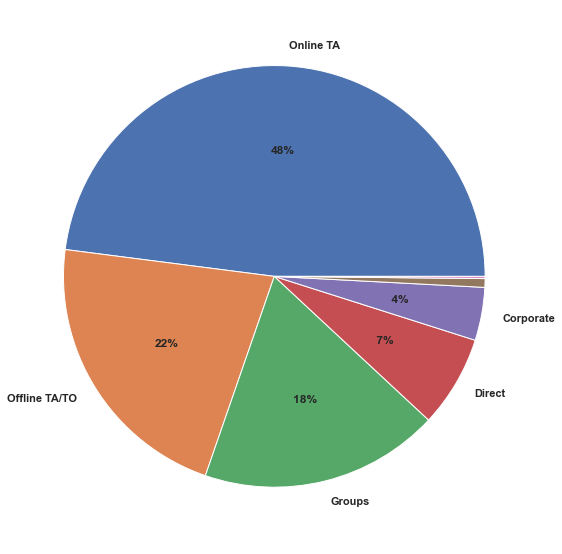

In [21]:
#Percentage Segment wise
i = 0
col_count = []
for col in data['segment'].value_counts().index:
    col_count.append([col, data['segment'].value_counts()[i]])
    i = i+1
    
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(8, 8))
col_count.sort(key = lambda x:x[1], reverse = True)
labels, sizes = zip(*col_count)
labels_selected = [n if v > sum(sizes) * 0.01 else '' for n, v in col_count]
ax.pie(sizes, labels=labels_selected,autopct = lambda x:'{:2.0f}%'.format(x) if x > 1 else '',
       shadow=False, startangle=0)
ax.axis('equal')
plt.tight_layout()

48% of the bookings are done using by Online Travel Agents.

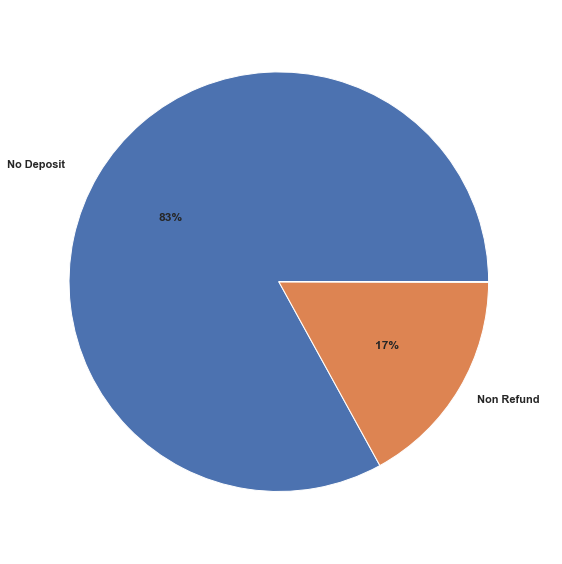

In [22]:
# Percent Deposit wise
i = 0
col_count = []
for col in data['deposit'].value_counts().index:
    col_count.append([col, data['deposit'].value_counts()[i]])
    i = i+1
    
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(8, 8))
col_count.sort(key = lambda x:x[1], reverse = True)
labels, sizes = zip(*col_count)
labels_selected = [n if v > sum(sizes) * 0.01 else '' for n, v in col_count]
ax.pie(sizes, labels=labels_selected,autopct = lambda x:'{:2.0f}%'.format(x) if x > 1 else '',
       shadow=False, startangle=0)
ax.axis('equal')
plt.tight_layout()

83% bookings chose for no deposits.

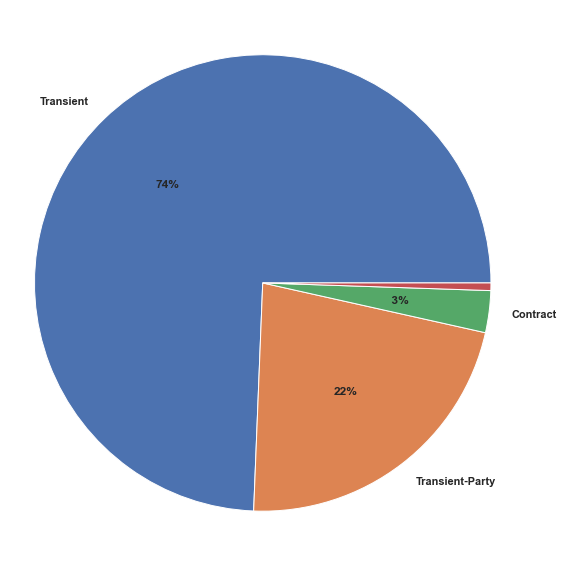

In [23]:
# Percent Customer Type wise
i = 0
col_count = []
for col in data['cust_type'].value_counts().index:
    col_count.append([col, data['cust_type'].value_counts()[i]])
    i = i+1
    
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(8, 8))
col_count.sort(key = lambda x:x[1], reverse = True)
labels, sizes = zip(*col_count)
labels_selected = [n if v > sum(sizes) * 0.01 else '' for n, v in col_count]
ax.pie(sizes, labels=labels_selected,autopct = lambda x:'{:2.0f}%'.format(x) if x > 1 else '',
       shadow=False, startangle=0)
ax.axis('equal')
plt.tight_layout()

74% of the overall booking belong to Transient type of customer type.

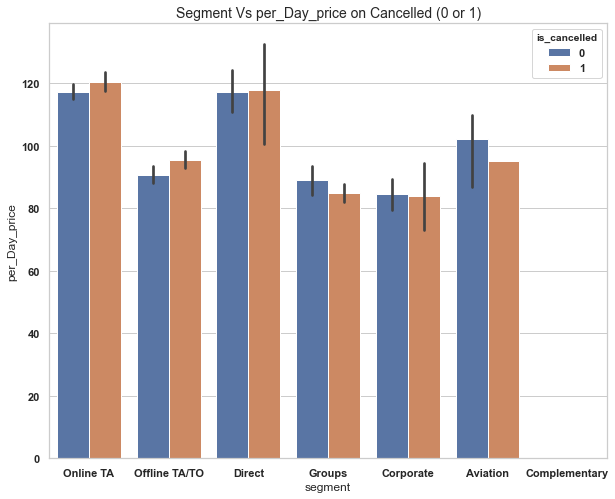

In [24]:
#Segment Vs per_Day_price on Cancelled (0 or 1)
plt.figure(figsize=(10, 8))
plt.title("Segment Vs per_Day_price on Cancelled (0 or 1)",fontsize = 14)
sns.barplot(x ="segment", y ="per_Day_price", 
            data=data, hue='is_cancelled')

The segment Online Travel Agents bookings has more cancellations whose per Day cost is around 120 USD.

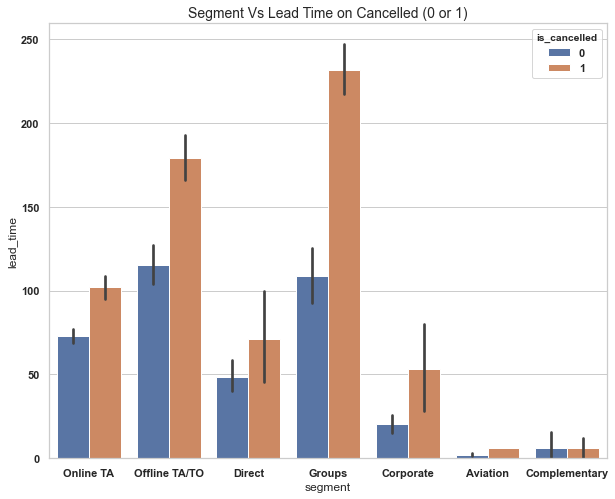

In [25]:
#Segment Vs Lead Time on Cancelled (0 or 1)
plt.figure(figsize=(10, 8))
plt.title("Segment Vs Lead Time on Cancelled (0 or 1)",fontsize = 14)
sns.barplot(x ="segment", y ="lead_time", 
            data=data, hue='is_cancelled')

The maximum cancellations is happening where the lead time is more than 200 days for the groups segment.

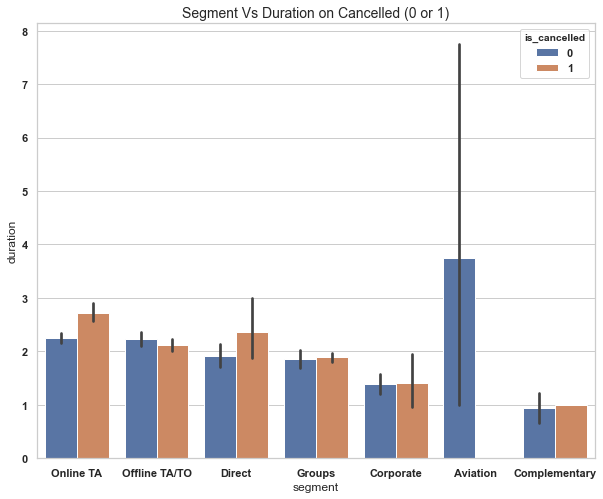

In [26]:
#Segment Vs Duration on Cancelled (0 or 1)
plt.figure(figsize=(10, 8))
plt.title("Segment Vs Duration on Cancelled (0 or 1)",fontsize = 14)
sns.barplot(x ="segment", y ="duration", 
            data=data, hue='is_cancelled')

There is no cancellations for the Aviation segment for people staying for longer duration. 

#### New Features

In [27]:
#Add new features 
data['total_charges'] = data['per_Day_price'] * data['duration']

Text(0, 0.5, 'Total Charges')

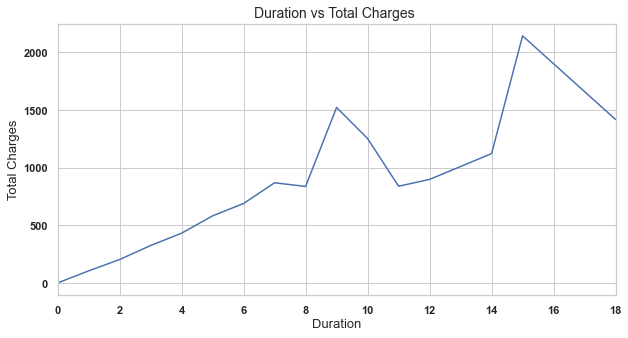

In [28]:
# Duration vs Total Charges
data.groupby('duration')['total_charges'].mean().plot()

plt.title("Duration vs Total Charges ",fontsize = 14)
plt.xlabel('Duration',fontsize = 13)
plt.ylabel('Total Charges',fontsize = 13)

The mean total charges for 15 days of staying is around 2142 USD.

#### Feature Correlation

Text(0.5, 1.0, 'Correlation between different fearures')

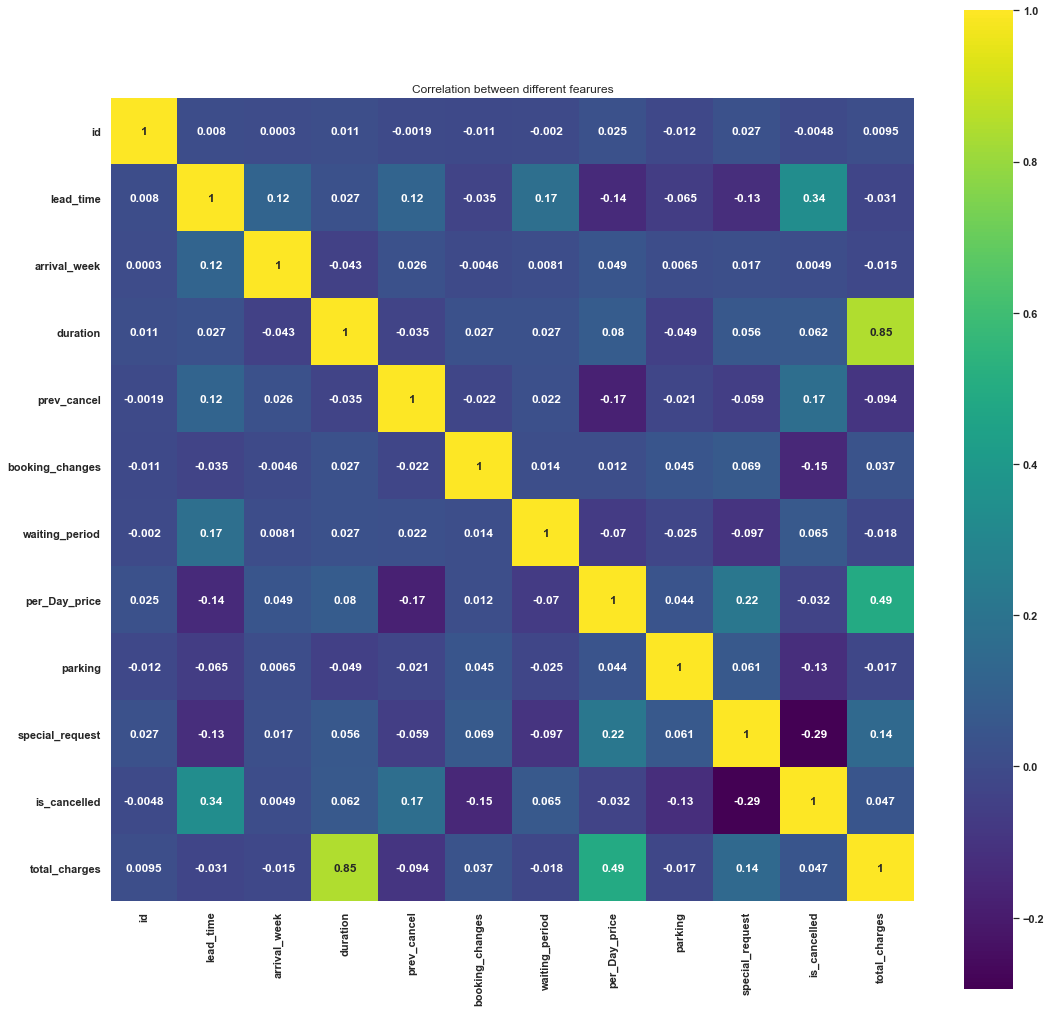

In [29]:
correlation = data.corr()
plt.figure(figsize=(18, 18))
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='viridis')

plt.title('Correlation between different fearures')


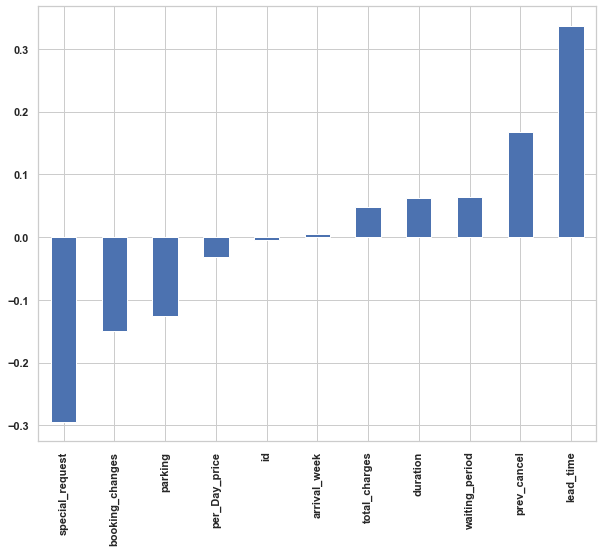

In [30]:
plt.figure(figsize=(10,8))
data.corr()['is_cancelled'].sort_values()[:-1].plot(kind='bar')
plt.show()

## Visualization, Modeling, Machine Learning

Build a classification model and to determine whether a customer will cancel a booking. Please explain the findings effectively to technical and non-technical audiences using comments and visualizations, if appropriate.
- **Build an optimized model that effectively solves the business problem.**
- **The model's performance will be evaluated on the basis of accuracy.**
- **Read the test.csv file and prepare features for testing.**

In [31]:
#Loading Test data
test_data=pd.read_csv('test.csv')
test_data.head()

,id,lead_time,arrival_week,duration,prev_cancel,booking_changes,waiting_period,per_Day_price,parking,special_request,segment,deposit,cust_type
0,3200,45,9,3,0,2,0,80.3,0,1,Online TA,No Deposit,Transient
1,3201,7,3,5,0,0,0,73.9,0,0,Online TA,No Deposit,Transient
2,3202,0,32,2,0,1,0,80.0,1,1,Online TA,No Deposit,Contract
3,3203,101,32,1,0,0,0,107.1,0,0,Online TA,No Deposit,Transient
4,3204,95,6,2,0,0,0,72.0,0,0,Offline TA/TO,No Deposit,Transient


In [32]:
#Add the features to test data
test_data['total_charges'] = test_data['per_Day_price'] * test_data['duration']

In [33]:
# Get the numerical and categorical variables 
numvars = ['id','lead_time','arrival_week',
           'duration','booking_changes','prev_cancel',
           'waiting_period','per_Day_price','parking',
           'special_request','total_charges','is_cancelled'
          ]
catvars = ['segment','deposit','cust_type']

#### Encoding

In [34]:
#Encoding categorical features
# Labelencoding to transform categorical to numerical
d = defaultdict(LabelEncoder)

# Encoding the variable
train_lecatdata = data[catvars].apply(lambda x: d[x.name].fit_transform(x))

# print transformations
for x in range(len(catvars)):
    print(catvars[x],": ", data[catvars[x]].unique())
    print(catvars[x],": ", train_lecatdata[catvars[x]].unique())

segment :  ['Online TA' 'Offline TA/TO' 'Direct' 'Groups' 'Corporate' 'Aviation'
 'Complementary']
segment :  [6 5 3 4 2 0 1]
deposit :  ['No Deposit     ' 'Non Refund     ' 'Refundable     ']
deposit :  [0 1 2]
cust_type :  ['Transient' 'Transient-Party' 'Contract' 'Group']
cust_type :  [2 3 0 1]


In [35]:
#Concat transformed datasets
# append the dummy variable of the initial numerical variables numvars
train = pd.concat([data[numvars], train_lecatdata], axis = 1)

In [36]:
# Set the title as index
train.set_index("id", inplace = True)

#Get the X and y for the data
X = train.drop('is_cancelled', axis=1)
y = train['is_cancelled']

# split into training and valid data set
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20)
print(X_train.shape,X_valid.shape)

(2400, 13) (600, 13)


### Modelling

In [37]:
algos = [
         "RandomForestClassifier",
         "Decision Tree",
         "Logistic Regression",
         "K Nearest Neighbor",
         "Naive Bayes"
        ]
clfs = [RandomForestClassifier(),
        DecisionTreeClassifier(),
        LogisticRegression(),
        KNeighborsClassifier(n_neighbors=2),
        naive_bayes.GaussianNB()
       ]
         
result = []

for clff in clfs:
    clff.fit(X_train,y_train)
    acc = clff.score(X_valid,y_valid)
    result.append(acc)
result_df = pd.DataFrame(result,index=algos)
result_df.columns=["Accuracy"]
result_df.sort_values(by="Accuracy",ascending=False)

/Users/apple/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


,Accuracy
RandomForestClassifier,0.845000
Logistic Regression,0.818333
Naive Bayes,0.805000
Decision Tree,0.795000
K Nearest Neighbor,0.738333


The accuracy is maximum for the RandomForestClassifier around 81%.

### Random Forest using Grid Search CV

In [38]:
#Grid Search Cross Validation to get the best 
#parameter for the best estimator i.e. Random Forest 
param_grid = {
            'n_estimators': [50, 100, 200],
            'max_features': [2, 3],
            'min_samples_leaf': [1, 2, 4],
            'min_samples_split': [2, 5, 10]
            }

#define the GridSearch
CV_rnd_cfl = GridSearchCV(estimator = RandomForestClassifier(), param_grid = param_grid, 
                          scoring = 'roc_auc', verbose = 10, n_jobs = -1,cv=5)
# fit the model
CV_rnd_cfl.fit(X, y)

best_parameters = CV_rnd_cfl.best_params_

print("The best parameters: ", best_parameters)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   30.9s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   37.4s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   42.6s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   46.3s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   49.1s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   52.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   57.6s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  1

The best parameters:  {'max_features': 3, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 50}


In [39]:
#From the  Grid Search CV get the best Random Forest parameters 
clf_r = RandomForestClassifier(max_features= best_parameters['max_features'], 
                             min_samples_leaf = best_parameters['min_samples_leaf'],
                              min_samples_split=best_parameters['min_samples_split'],
                              n_estimators = best_parameters['n_estimators'])
# fit the model
clf_r.fit(X,y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=3,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [40]:
#Label encoding for the test data
test_lecatdata = test_data[catvars].apply(lambda x: d[x.name].transform(x))

test = pd.concat([test_data[numvars[:-1]], test_lecatdata], axis = 1)
#set the title
test.set_index('id',inplace=True)

In [41]:
# Predict the test data
y_predict = clf_r.predict(test)
test['is_cancelled'] = y_predict

### Feature Importance


**The the most important features of the model to management.**

- **Visualize the top 10 features and their feature importance.**


In [42]:
print('Total number of feature:{}'.format(len(train.columns)))

Total number of feature:14


Text(0.5, 0, 'Feature names')

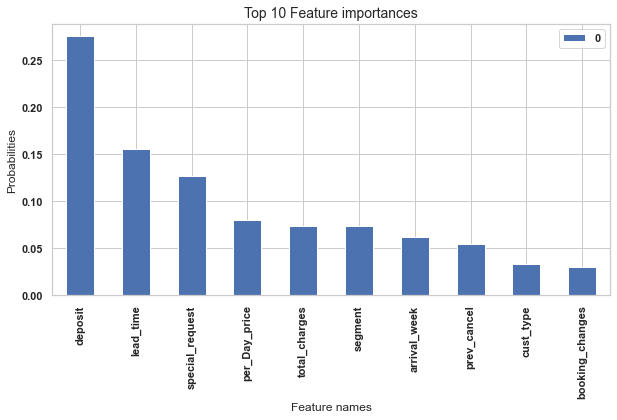

In [43]:
# Get the feature importance from the Random Forest
feature_imp = pd.DataFrame(clf_r.feature_importances_,index=X.columns)
feature_imp.sort_values(by = 0 , ascending = False)[:10].plot(kind='bar',align="center")
plt.title("Top 10 Feature importances",fontsize = 14)
plt.ylabel('Probabilities',fontsize = 12)
plt.xlabel('Feature names',fontsize = 12)

In [44]:
feature_imp.sort_values(by = 0 , ascending = False)[:10]

,0
deposit,0.275063
lead_time,0.155089
special_request,0.126502
per_Day_price,0.079997
total_charges,0.073801
segment,0.073767
arrival_week,0.062082
prev_cancel,0.054013
cust_type,0.033652
booking_changes,0.030511


> #### Task:
- **Submit the predictions on the test dataset using your optimized model** <br/>
    For each record in the test set (`test.csv`), you must predict whether a customer will cancel his booking or not. You should submit a CSV file with a header row and one row per test entry. 

The file (`submissions.csv`) should have exactly 2 columns:
   - **id**
   - **is_cancelled**
   

In [45]:
# Create a submission_df
d = {'id': test.index, 'is_cancelled': y_predict}
submission_df = pd.DataFrame(data=d)
submission_df[:5]

,id,is_cancelled
0,3200,0
1,3201,0
2,3202,0
3,3203,1
4,3204,0


In [46]:
#Submission
submission_df.to_csv('submissions.csv',index=False)